In [12]:
#Notebook's settings
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#from jupyterthemes import jtplot
#jtplot.reset()

# Plotting

import sys
Folder='/Users/egordanilov/Desktop/Lesta_shared/GRF_strong_lensing/jax-strong-lensing/'
sys.path.append(Folder)

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
#%matplotlib inline


# Basic imports
import numpy as np
from copy import deepcopy
import pandas as pd
from tqdm import tqdm
import math
import time
import scipy as sc

#JAX
import jax
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)
config.update("jax_debug_nans", True)

from GRF_perturbations.Modules.GRF_inhomogeneities_class import *
from GRF_perturbations.Modules.Surface_Brightness_class import Surface_brightness_class
from GRF_perturbations.Modules.Utils import scipy_fit_Surface_Brightness
from GRF_perturbations.Modules.Inference_class import Inference_class

import os
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=%d"%(8)

#Fontsize
FS=18

In [9]:
GRF_class=GRF_inhomogeneities_class(100, 0.08, 100)
Surface_brightness=Surface_brightness_class(100,0.08,0.1,200,2028)
Inference=Inference_class(GRF_class,Surface_brightness,Grad_descent_max_iter=400)

In [13]:
Noise_spectra.shape

(1000, 46)

In [24]:
Mean_noise=np.log(Noise_spectra).mean(axis=0)
Std_noise=np.sqrt(np.power(np.log(Noise_spectra)-Mean_noise,2).sum(axis=0)/(len(Noise_spectra)-1))

In [25]:
Std_noise

array([0.36759085, 0.30310972, 0.28930532, 0.26967914, 0.24483931,
       0.24399378, 0.22387352, 0.21364589, 0.20551178, 0.19200678,
       0.17938633, 0.17045871, 0.17859157, 0.15934136, 0.16043445,
       0.16261235, 0.16056031, 0.1568023 , 0.1524812 , 0.14797862,
       0.13846443, 0.14135507, 0.14137081, 0.13474754, 0.13177901,
       0.12765366, 0.12467477, 0.12130096, 0.12628523, 0.12054228,
       0.11637153, 0.12693589, 0.11618583, 0.11777191, 0.11366618,
       0.11273362, 0.1094624 , 0.10611792, 0.10453797, 0.10704422,
       0.10572417, 0.10409692, 0.1010136 , 0.10268312, 0.10219986,
       0.10289341])

<ErrorbarContainer object of 3 artists>

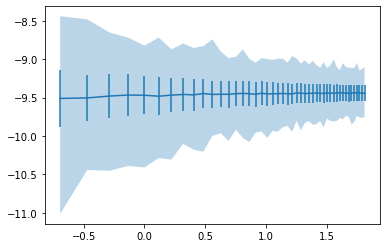

In [26]:
plt.fill_between(np.log(Surface_brightness.frequencies),np.log(Noise_spectra).min(axis=0),np.log(Noise_spectra).max(axis=0),alpha=0.3)
plt.errorbar(np.log(Surface_brightness.frequencies),Mean_noise,Std_noise)

In [13]:
from GRF_perturbations.Modules.Utils import jax_map
compute_spectrum_pure=lambda unit_Fourier_image: Inference.Anomalies_Radial_Power_Spectrum(jnp.array([-7.7,1.75]),unit_Fourier_image)

In [14]:
model_spectra=jax.pmap(compute_spectrum_pure)(GRF_class.tensor_unit_Fourier_images[:8])

In [15]:
model_spectra.shape

(8, 46)

In [22]:
# Perturbations+Noise should have more power than just noise
        self.assertTrue((self.Perturbations_spectra.sum(axis=1)>PS_Noise.sum()).all())
        

        # Powerlaw fits
        logAs=np.zeros(32)
        Betas=np.zeros(32)
        for i in range(32):
            fit_results, _ = scipy.optimize.curve_fit(power_law_function, self.Surface_brightness.frequencies, self.Perturbations_spectra[i])
            logAs[i]=fit_results[0]
            Betas[i]=fit_results[1]
            
        # Spectrum of perturbations should not be flat
        self.assertTrue((Betas > 0.1).all())

4

In [17]:
max_thread_numbers

8

In [4]:
        # Check that we can take gradients wrp fitted data
        test_func= jax.jit(lambda data:  Inference.Loss_unperturbed_model(
                            Inference.differentiable_fit_Surface_Brightness(data),data))
        Grads_of_Loss_final=jax.grad(test_func)(np.zeros((100,100)))

In [9]:
(np.abs(Grads_of_Loss_final)>0).all()

True

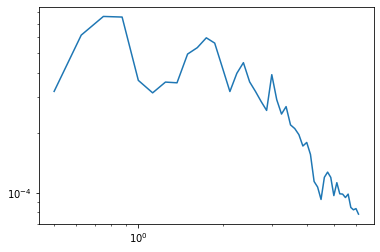

In [28]:
data_spec=Inference.Anomalies_Radial_Power_Spectrum([-7.8, 2],GRF_class.tensor_unit_Fourier_images[0])
plt.loglog(Surface_brightness.frequencies,data_spec)

In [29]:
from GRF_perturbations.Modules.Utils import Spectra_Loss

In [30]:
def Spectra_Loss_MSE(model_spectra,data_spectrum,Number_of_spectra):

    data_log_spectrum=jnp.log(data_spectrum)
    models_log_spectra=jnp.log(model_spectra)

    Mean_logN=models_log_spectra.mean(axis=-2)
    Sigma_logN=jnp.sqrt(jnp.power(models_log_spectra-Mean_logN,2).sum(axis=-2)/
                      (Number_of_spectra-1))

    #Chi^2 loss for Normal likelihood of log(Power_spectrum)
    return jnp.mean(jnp.power((data_log_spectrum - Mean_logN), 2), axis=-1)

In [31]:
Number_of_spectra=20
Spectra_Loss_function=lambda model_spectra: Spectra_Loss_MSE(model_spectra,data_spec,Number_of_spectra)
GRF_Loss=jax.jit(lambda GRF_params: Inference.GRF_Power_Spectrum_Loss(GRF_params,Number_of_spectra,Spectra_Loss_function))
GRF_grad_Loss=jax.jit(jax.grad(GRF_Loss))

In [32]:
import time

In [33]:
start_time=time.time()
print(GRF_Loss([-7.6,2.]),time.time()-start_time)

0.1283514203127388 19.822000980377197


In [ ]:
start_time=time.time()
print(GRF_grad_Loss([-7.6,2.]),time.time()-start_time)

In [15]:
def Spectra_Loss_weighted(model_spectra,data_spectrum,Number_of_spectra):

    data_log_spectrum=jnp.log(data_spectrum)
    models_log_spectra=jnp.log(model_spectra)

    Mean_logN=models_log_spectra.mean(axis=-2)
    Sigma_logN=jnp.sqrt(jnp.power(models_log_spectra-Mean_logN,2).sum(axis=-2)/
                      (Number_of_spectra-1))
    #Chi^2 loss for Normal likelihood of log(Power_spectrum)
    return jnp.mean(jnp.power((data_log_spectrum - Mean_logN)/Sigma_logN, 2), axis=-1)

In [17]:
np.random.normal?

In [24]:
data_spec*np.random.normal(scale=1,size=46)

DeviceArray([7.58414917e-04, 1.13697715e-03, 9.68172736e-04,
             9.45275104e-04, 3.56550654e-04, 3.56716874e-04,
             2.85119546e-04, 3.48831918e-04, 4.70516196e-04,
             5.31468103e-04, 5.82713854e-04, 5.66331402e-04,
             4.20044825e-04, 3.35913737e-04, 3.84842436e-04,
             4.37667186e-04, 3.61538971e-04, 3.11813506e-04,
             3.03773507e-04, 2.63816698e-04, 3.75305296e-04,
             3.04590608e-04, 2.70860285e-04, 2.81396046e-04,
             2.05979627e-04, 2.06690578e-04, 2.09896634e-04,
             1.65300877e-04, 1.85386523e-04, 1.64340831e-04,
             1.05647357e-04, 1.07383332e-04, 6.10701065e-05,
             1.10088618e-04, 1.24811280e-04, 1.08035797e-04,
             1.13965086e-04, 9.88033158e-05, 9.51581942e-05,
             1.00351267e-04, 1.09678221e-04, 8.52009591e-05,
             9.62872455e-05, 8.25646159e-05, 7.38199986e-05,
             8.29145700e-05], dtype=float64)

In [25]:
data_spec

DeviceArray([7.65718583e-04, 1.13481256e-03, 9.67717018e-04,
             9.51791107e-04, 3.35111213e-04, 3.50377684e-04,
             3.05370972e-04, 3.46967375e-04, 4.77134060e-04,
             5.22943770e-04, 5.90639062e-04, 5.67478766e-04,
             4.14994952e-04, 3.27256185e-04, 3.96845401e-04,
             4.41012199e-04, 3.66288424e-04, 3.18346798e-04,
             2.86118965e-04, 2.59766881e-04, 3.87914135e-04,
             2.95411988e-04, 2.49638723e-04, 2.71071393e-04,
             2.21173327e-04, 2.11532918e-04, 1.97227523e-04,
             1.72377572e-04, 1.80948328e-04, 1.56594491e-04,
             1.14916661e-04, 1.07978585e-04, 9.34827799e-05,
             1.20332495e-04, 1.27336962e-04, 1.20513628e-04,
             9.76409731e-05, 1.13104730e-04, 9.95586391e-05,
             9.90438616e-05, 9.52654884e-05, 9.95595806e-05,
             8.46556079e-05, 8.24622853e-05, 8.36350851e-05,
             7.82935352e-05], dtype=float64)

In [22]:
Spectra_Loss_weighted(np.tile(data_spec+np.random.normal(scale=1e-5,size=46),10).reshape((10,46)),data_spec,10)

DeviceArray(inf, dtype=float64)

In [34]:
    def GRF_Power_Spectrum_Loss(self,GRF_params,GRF_seeds_number,Spectra_Loss_function,Noise=True):
        # Set of random Fourier images representing different GRF field realisations
        unit_Fourier_images=self.GRF_inhomogeneities.tensor_unit_Fourier_images[:GRF_seeds_number]

        # Simulate Radial Power spectra for Surface Brightness Anomalies images generated for every GRF potential realisation
        getter_SB_Anomalies_spectra=jax.jit(lambda unit_Fourier_image: self.Anomalies_Radial_Power_Spectrum(GRF_params,unit_Fourier_image,Noise))
        
        return getter_SB_Anomalies_spectra

In [35]:
getter=GRF_Power_Spectrum_Loss(Inference,[-7.6,2],Number_of_spectra,Spectra_Loss_function)

In [36]:
q=Inference.Anomalies_Radial_Power_Spectrum([-7.6,2],GRF_class.tensor_unit_Fourier_images[0],True)

In [37]:
q

DeviceArray([5.41111327e-04, 7.53279997e-04, 8.94248619e-04,
             9.73938196e-04, 5.54528011e-04, 4.09073715e-04,
             6.30603060e-04, 5.02116751e-04, 5.55592416e-04,
             6.80770477e-04, 8.17360822e-04, 7.05729137e-04,
             6.39170789e-04, 4.18674859e-04, 5.50453354e-04,
             5.63459636e-04, 5.35252722e-04, 4.85006045e-04,
             3.79436711e-04, 3.75293798e-04, 3.90144948e-04,
             4.37974499e-04, 3.38793038e-04, 3.75076471e-04,
             3.13830247e-04, 3.15487318e-04, 2.66458582e-04,
             2.23568342e-04, 2.05880222e-04, 2.03574253e-04,
             1.57946060e-04, 1.86101710e-04, 1.47940957e-04,
             1.39684781e-04, 1.40640468e-04, 1.14766695e-04,
             1.39197192e-04, 1.48948901e-04, 1.49851249e-04,
             1.00264844e-04, 1.03197471e-04, 1.00706144e-04,
             1.05074892e-04, 8.99212725e-05, 9.88324167e-05,
             8.74683147e-05], dtype=float64)

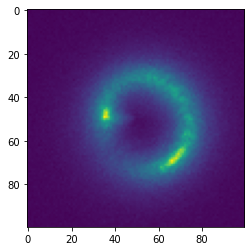

In [12]:
plt.imshow(data_spec)

In [3]:
from GRF_perturbations.Modules.Utils import Spectrum_radial_averaging
import scipy

In [4]:
simulate_perturbed_image=Surface_brightness.perturbed_image_getter

In [27]:
        logA_array = [-8.5,-8.2, -7.8,-7.5, -7.3]
        Beta_array = [0,1, 2,3, 4]

        #Perturbed surface brightness mocks for tests
        Images = np.zeros((5, 100, 100, 100))
        for i in range(5):
            # 100 realisations for tests
            for seed in range(100):
                GRF_potential = GRF_class.potential([logA_array[i], Beta_array[i]],GRF_class.tensor_unit_Fourier_images[seed])
                Images[i, seed] = np.array([simulate_perturbed_image(GRF_potential, Noise_flag=True)])

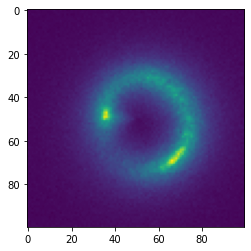

In [28]:
plt.imshow(Images[2,0])

In [29]:
q=scipy_fit_Surface_Brightness(Images[2,0],Surface_brightness)

In [30]:
    #Initialize image generation function
    simulate_unperturbed_image = Surface_brightness.unperturbed_image_getter
    simulate_unperturbed_image_pure = lambda model_kwargs: simulate_unperturbed_image(model_kwargs, Noise_flag=False)
    # args<->kwargs transformation
    SL_parameters=Surface_brightness.parameters()

In [33]:

        # Functions for image generation
        simulate_unperturbed_image = Surface_brightness.unperturbed_image_getter
        simulate_unperturbed_image_noiseless = lambda model_kwargs: simulate_unperturbed_image(model_kwargs,Noise_flag=False)
        simulate_perturbed_image = Surface_brightness.perturbed_image_getter

        # Images for fitting to be tested on
        Image_unperturbed_noiseless=simulate_unperturbed_image_noiseless(Surface_brightness.kwargs_unperturbed_model)
        Image_unperturbed_noisy=simulate_unperturbed_image(Surface_brightness.kwargs_unperturbed_model,Noise_flag=True,noise_seed=18)
        GRF_potential = GRF_class.potential([-7.8, 2], GRF_class.tensor_unit_Fourier_images[0])
        Image_perturbed_noisy=simulate_perturbed_image(GRF_potential,Noise_flag=True,noise_seed=42)

In [46]:
        fits=[]
        losses=np.zeros(3)
        for i,data in enumerate([Image_unperturbed_noiseless,Image_unperturbed_noisy,Image_perturbed_noisy]):
            fit=scipy_fit_Surface_Brightness(data,Surface_brightness,method='Newton-CG')
            fits+=[fit]
            losses[i]=Loss_function(SL_parameters.kwargs2args(fit),data)

In [47]:
losses

array([1.08824186e-11, 9.89635704e-01, 1.28405795e+00])

In [45]:
fits[0]

{'kwargs_lens': [{'theta_E': DeviceArray(1.67555657, dtype=float64),
   'e1': DeviceArray(-0.37416735, dtype=float64),
   'e2': DeviceArray(0.06932655, dtype=float64),
   'center_x': DeviceArray(0.6496228, dtype=float64),
   'center_y': DeviceArray(0.41917338, dtype=float64)},
  {'gamma1': DeviceArray(-0.14671854, dtype=float64),
   'gamma2': DeviceArray(0.06192665, dtype=float64),
   'ra_0': 0.0,
   'dec_0': 0.0}],
 'kwargs_source': [{'amp': DeviceArray(9.40934445, dtype=float64),
   'R_sersic': DeviceArray(1.26751096, dtype=float64),
   'n_sersic': DeviceArray(1.3723577, dtype=float64),
   'e1': DeviceArray(0.13165482, dtype=float64),
   'e2': DeviceArray(-0.10444182, dtype=float64),
   'center_x': DeviceArray(0.42259959, dtype=float64),
   'center_y': DeviceArray(0.15507423, dtype=float64)}],
 'kwargs_lens_light': []}

In [34]:
q=scipy_fit_Surface_Brightness(Image_unperturbed_noiseless,Surface_brightness)
Loss_function(SL_parameters.kwargs2args(q),Image_unperturbed_noiseless)

/usr/local/Caskroom/miniforge/base/envs/env_jax/lib/python3.8/site-packages/scipy/optimize/_minimize.py:527: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  warn('Method %s does not use Hessian information (hess).' % method,


DeviceArray(2.4828439, dtype=float64)

In [35]:
q=scipy_fit_Surface_Brightness(Image_unperturbed_noisy,Surface_brightness)
Loss_function(SL_parameters.kwargs2args(q),Image_unperturbed_noisy)

DeviceArray(3.47548353, dtype=float64)

In [36]:
q=scipy_fit_Surface_Brightness(Image_perturbed_noisy,Surface_brightness)
Loss_function(SL_parameters.kwargs2args(q),Image_perturbed_noisy)

/usr/local/Caskroom/miniforge/base/envs/env_jax/lib/python3.8/site-packages/scipy/optimize/_minimize.py:527: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  warn('Method %s does not use Hessian information (hess).' % method,


DeviceArray(3.64121933, dtype=float64)

In [32]:
Loss_function(SL_parameters.kwargs2args(q),Images[2,0])

DeviceArray(3.64121933, dtype=float64)

In [14]:
Surface_brightness.kwargs_unperturbed_model

{'kwargs_lens': [{'theta_E': 1.6,
   'e1': 0.15,
   'e2': -0.04,
   'center_x': 0.0,
   'center_y': 0.0},
  {'gamma1': -0.01, 'gamma2': 0.03, 'ra_0': 0.0, 'dec_0': 0.0}],
 'kwargs_source': [{'amp': 10.0,
   'R_sersic': 1.2,
   'n_sersic': 1.5,
   'center_x': 0.4,
   'center_y': 0.15,
   'e1': 0.07,
   'e2': -0.1}],
 'kwargs_lens_light': [{}]}

In [133]:
GRF_class=GRF_inhomogeneities_class(100,0.08,100)

In [21]:
#Default models of source galaxy and lens galaxy
default_source_light_model_list = ['SERSIC_ELLIPSE']
default_lens_mass_model_list = ['SIE', 'SHEAR']
default_lens_light_model_list = []

#Default model parameters of source galaxy and lens galaxy
default_unperturbed_model_kwargs={'kwargs_lens': [{'theta_E': 1.6, 'e1': 0.15, 'e2': -0.04, 'center_x': 0.0, 'center_y': 0.0},
                                                  {'gamma1': -0.01, 'gamma2': 0.03, 'ra_0': 0.0, 'dec_0': 0.0}],
                                  'kwargs_source': [{'amp': 10.0, 'R_sersic': 1.2, 'n_sersic': 1.5, 'center_x': 0.4, 'center_y': 0.15,'e1':0.07,'e2':-0.1}],
                                  'kwargs_lens_light': [{}]}

In [134]:
from GRF_perturbations.Modules.Surface_Brightness_class import Surface_brightness_class

In [135]:
Surface_brightness=Surface_brightness_class(100,0.08,0.1,200,2028)

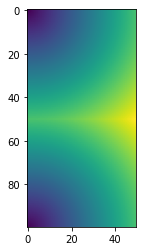

In [26]:
plt.imshow(GRF_class.k_grid[:,:50])

In [6]:
simulate_perturbed_image=Surface_brightness.perturbed_image_getter
simulate_unperturbed_image=Surface_brightness.unperturbed_image_getter

In [7]:
GRF_potential=GRF_class.potential([-10,2],GRF_class.tensor_unit_Fourier_images[0])

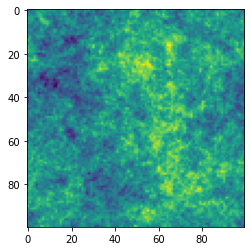

In [8]:
plt.imshow(GRF_potential)

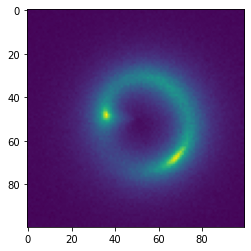

In [9]:
plt.imshow(simulate_perturbed_image(GRF_potential,Noise_flag=True))

In [10]:
plt.imshow(simulate_unperturbed_image(Surface_brightness.unperturbed_model_kwargs,Noise_flag=True))

AttributeError: 'Surface_brightness_class' object has no attribute 'unperturbed_model_kwargs'

In [73]:
simulate_unperturbed_image = Surface_brightness.unperturbed_image_getter
Images=np.array([simulate_unperturbed_image(Surface_brightness.kwargs_unperturbed_model,noise_seed=i)
                         for i in range(1000)])
i,j=np.unravel_index(np.argmax(Images[0]),shape=Images[0].shape)

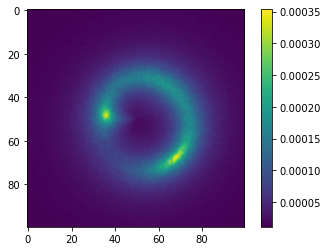

In [74]:
plt.imshow(Images.var(axis=0))
plt.colorbar()

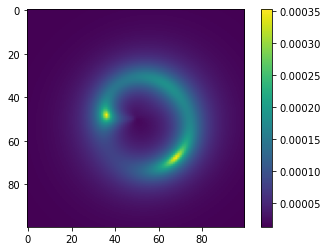

In [75]:
plt.imshow(Surface_brightness.noise_var)
plt.colorbar()

In [76]:
q=np.abs(Images.var(axis=0)-Surface_brightness.noise_var)/Surface_brightness.noise_var

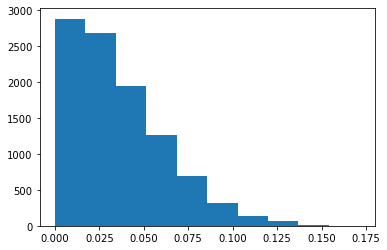

In [77]:
plt.hist(q.flatten())
plt.show()

In [ ]:
Images

In [78]:
i,j=np.unravel_index(np.argmax(Images[0]),shape=Images[0].shape)

In [80]:
i, j = np.unravel_index(np.argmax(Images[0]), shape=Images[0].shape)
bkg_noise_std=np.sqrt(Surface_brightness.noise_var[0,0])

In [81]:
bkg_noise_std

0.0035118420186725126

In [86]:
np.abs(Images[:,i,j]/bkg_noise_std/200-1).max()

0.1219329647515387

(array([  6.,  33.,  88., 212., 246., 220., 121.,  56.,  15.,   3.]),
 array([0.86788419, 0.88475129, 0.90161838, 0.91848548, 0.93535257,
        0.95221967, 0.96908676, 0.98595386, 1.00282095, 1.01968805,
        1.03655514]),
 <BarContainer object of 10 artists>)

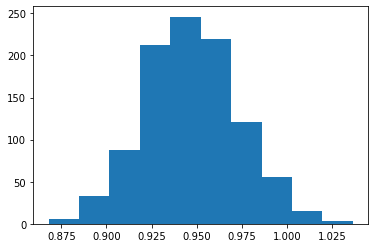

In [28]:
plt.hist(Images[:,i,j]/Surface_brightness.noise_var/200)

In [35]:
np.tile([[1,2],[2,3]],3)

array([[1, 2, 1, 2, 1, 2],
       [2, 3, 2, 3, 2, 3]])

In [40]:
np.repeat([[[1,2],[2,3]]],3*3,axis=0).reshape((3,3,2,2))

array([[[[1, 2],
         [2, 3]],

        [[1, 2],
         [2, 3]],

        [[1, 2],
         [2, 3]]],


       [[[1, 2],
         [2, 3]],

        [[1, 2],
         [2, 3]],

        [[1, 2],
         [2, 3]]],


       [[[1, 2],
         [2, 3]],

        [[1, 2],
         [2, 3]],

        [[1, 2],
         [2, 3]]]])

In [12]:
        logA_array = [-8.5,-8.2, -7.8,-7.5, -7.3]
        Beta_array = [0,1, 2,3, 4]

        #Perturbed surface brightness mocks for tests
        Images = np.zeros((5, 100, 100, 100))
        for i in range(5):
            # 100 realisations for tests
            for seed in range(100):
                GRF_potential = GRF_class.potential([logA_array[i], Beta_array[i]],GRF_class.tensor_unit_Fourier_images[seed])
                Images[i, seed] = np.array([simulate_perturbed_image(GRF_potential, Noise_flag=False)])


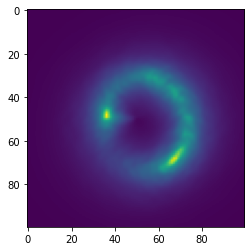

In [13]:
plt.imshow(Images[4,0])

In [117]:
p=Images.var(axis=1)

In [145]:
q=(Images-unperturbed_Image)

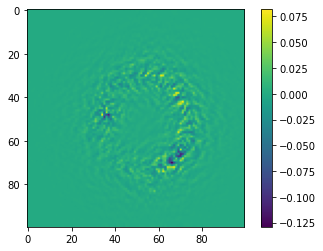

In [149]:
plt.imshow(q[0,3])
plt.colorbar()
plt.show()

In [14]:
unperturbed_Image=simulate_unperturbed_image(Surface_brightness.kwargs_unperturbed_model,Noise_flag=False)

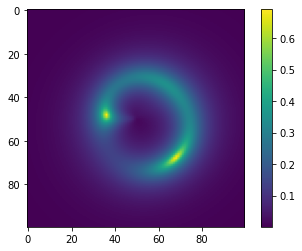

In [15]:
plt.imshow(unperturbed_Image)
plt.colorbar()
plt.show()

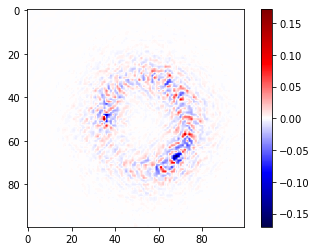

In [16]:
i=0
plt.imshow(Images[i,0]-unperturbed_Image,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
plt.colorbar()
plt.show()

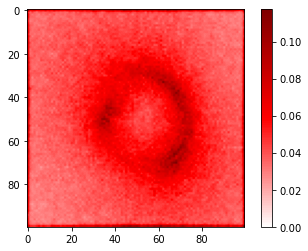

In [134]:
i=0
plt.imshow((Images[i,:]-unperturbed_Image).std(axis=0)/unperturbed_Image,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
plt.colorbar()
plt.show()

In [17]:
SB_Anomalies=Images-unperturbed_Image

In [18]:
from GRF_perturbations.Modules.Image_processing import compute_radial_spectrum

In [19]:
compute_radial_spectrum_pure=jax.jit(lambda image: compute_radial_spectrum(image,Surface_brightness.annulus_mask,GRF_class.k_grid,Surface_brightness.frequencies))

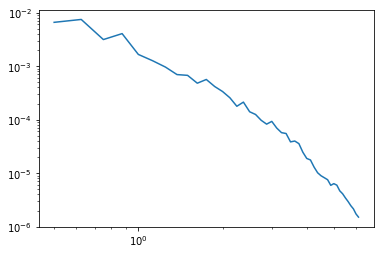

In [20]:
plt.loglog(Surface_brightness.frequencies,compute_radial_spectrum_pure(SB_Anomalies[5,0]))

In [27]:
        # Perturbed surface brightness mocks for tests
        Images = np.zeros((5, 100, 100, 100))
        SB_Anomalies_spectra = np.zeros((5, 100, len(Surface_brightness.frequencies)))
        for i in tqdm(range(5)):
            # 100 realisations for tests
            for seed in range(100):
                GRF_potential = GRF_class.potential([logA_array[i], Beta_array[i]],
                                                         GRF_class.tensor_unit_Fourier_images[seed])
                Images[i, seed] = np.array([simulate_perturbed_image(GRF_potential, Noise_flag=False)])
                SB_Anomalies_spectra[i,seed]=compute_radial_spectrum_pure(Images[i,seed]-unperturbed_Image)

100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.04it/s]


In [28]:
SB_Anomalies_spectra.shape

(5, 100, 46)

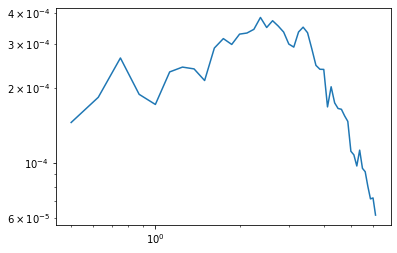

In [32]:
plt.loglog(Surface_brightness.frequencies,SB_Anomalies_spectra[0,1])

In [33]:
from scipy.optimize import curve_fit

In [43]:
logAs=np.zeros((5,100))
Betas=np.zeros((5,100))

for i in tqdm(range(5)):
    # 100 realisations for tests
    for seed in range(100):
        res,_=curve_fit(lambda k,logA,Beta: np.power(10,logA)*np.power(k,-Beta),Surface_brightness.frequencies,SB_Anomalies_spectra[i,seed])
        logAs[i,seed]=res[0]
        Betas[i,seed]=res[1]

100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 29.38it/s]


In [62]:
import scipy

In [63]:
scipy.optimize.curve_fit

<function scipy.optimize.minpack.curve_fit(f, xdata, ydata, p0=None, sigma=None, absolute_sigma=False, check_finite=True, bounds=(-inf, inf), method=None, jac=None, **kwargs)>

In [45]:
logAs[:,0]

array([-3.35483038, -3.49373113, -3.30635071, -3.0624983 , -2.6931539 ])

In [46]:
Betas[:,0]

array([0.42652521, 0.52792574, 0.96242698, 1.46901236, 1.96232307])

In [47]:
import scipy as sc

In [53]:
n=5
m=100

In [58]:
logAs.shape

(5, 100)

2.09653605431773e-70

In [70]:
q.

2.09653605431773e-70

In [60]:
logAs.T[0]

array([-3.35483038, -3.49373113, -3.30635071, -3.0624983 , -2.6931539 ])

In [52]:
sc.stats.spearmanr(logAs[:,0],[-8.5,-8.2, -7.8,-7.5, -7.3])

SpearmanrResult(correlation=0.8999999999999998, pvalue=0.03738607346849875)

In [51]:
logAs[:,0]

array([-3.35483038, -3.49373113, -3.30635071, -3.0624983 , -2.6931539 ])

In [38]:
Beta

array([[0.00174807, 0.00278117],
       [0.00278117, 0.0073924 ]])

(array([ 2.,  6., 12., 14., 13., 16., 15.,  8.,  9.,  5.]),
 array([-0.04085908, -0.03277725, -0.02469541, -0.01661358, -0.00853175,
        -0.00044991,  0.00763192,  0.01571375,  0.02379559,  0.03187742,
         0.03995926]),
 <BarContainer object of 10 artists>)

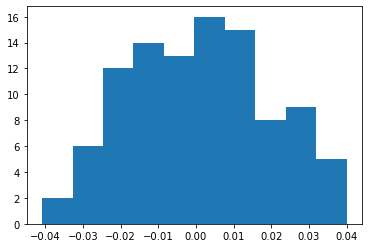

In [152]:
plt.hist((Images[i,:].sum(axis=(-1,-2))-unperturbed_Image.sum())/unperturbed_Image.sum())

In [136]:
unperturbed_Image.sum()

DeviceArray(678.5164743, dtype=float64)

In [150]:
Tensor_unperturbed_Image=np.repeat([unperturbed_Image],5*100,axis=0).reshape((5,100,100,100))

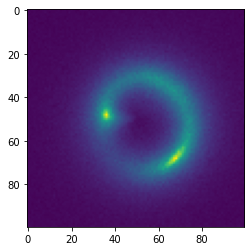

In [84]:
p[0,0]

array([[1.13477963e-05, 1.46204863e-05, 1.26627999e-05, ...,
        9.85200958e-06, 1.14950066e-05, 1.51172715e-05],
       [1.25035959e-05, 1.43083084e-05, 1.30017368e-05, ...,
        1.13124484e-05, 1.17318385e-05, 1.12747043e-05],
       [1.40644767e-05, 1.10489819e-05, 1.21361331e-05, ...,
        1.35413591e-05, 1.07767469e-05, 1.52348158e-05],
       ...,
       [1.14231616e-05, 1.49353095e-05, 1.42454035e-05, ...,
        1.13796216e-05, 1.22381224e-05, 1.45604465e-05],
       [9.59947890e-06, 1.13588694e-05, 1.28367554e-05, ...,
        1.45097422e-05, 1.17821302e-05, 1.47707972e-05],
       [1.56065932e-05, 1.14303085e-05, 1.26280841e-05, ...,
        1.35103749e-05, 1.55322422e-05, 1.31806693e-05]])

In [72]:
for i, logA in tqdm(enumerate(logA_array)):
    for j, Beta in enumerate(Beta_array):
        if not (Tensor_noise_var[i,j]!=Surface_brightness.noise_var).all():

            print(i,j)

3it [00:00, 60.16it/s]

0 0
0 1
0 2
1 0
1 1
1 2
2 0
2 1
2 2


In [79]:
bad_ind

(2, 0, 61, 62)

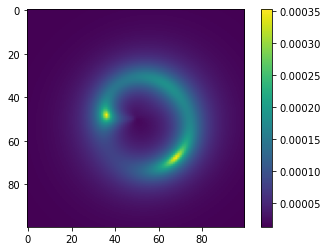

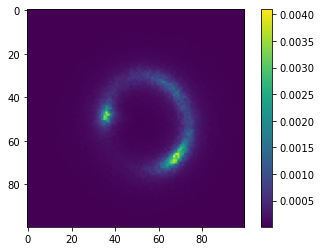

In [114]:
i=0
plt.imshow(Tensor_noise_var[i])
plt.colorbar()
plt.show()
plt.imshow(p[i])
plt.colorbar()
plt.show()

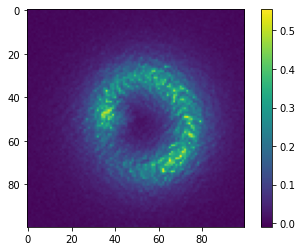

In [86]:
plt.imshow(Images[2,0,0])
plt.colorbar()
plt.show()

In [61]:
q=(p-Tensor_noise_var)/Tensor_noise_var

In [62]:
q.shape

(3, 3, 100, 100)

(array([8.4143e+04, 2.4130e+03, 1.1840e+03, 6.9800e+02, 6.7400e+02,
        5.2900e+02, 2.4400e+02, 8.0000e+01, 2.7000e+01, 8.0000e+00]),
 array([-0.47451708,  6.64138763, 13.75729234, 20.87319705, 27.98910176,
        35.10500647, 42.22091118, 49.33681589, 56.45272061, 63.56862532,
        70.68453003]),
 <BarContainer object of 10 artists>)

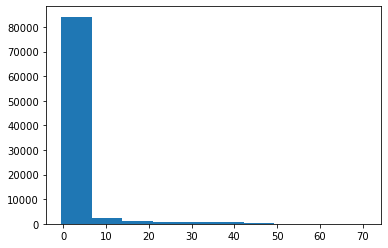

In [63]:
plt.hist(q.flatten())

In [65]:
bad_ind=np.unravel_index(np.argmax(q),shape=q.shape)

In [66]:
q[bad_ind]

70.68453002813717

In [67]:
p[bad_ind]

0.004756272078891192

In [68]:
Tensor_noise_var[bad_ind]

6.635004898580334e-05